In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error,r2_score

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [820]:
data_g=pd.read_excel('./Data Science Test/Train.xlsx')
data_g.loc[:,'Time_data']=pd.to_datetime(data_g['YearMonth'],format='%Y%m')
if 'Time_data' in data_g.columns:
    data_g.set_index('Time_data',inplace=True)
data_req=data_g[['Volume']].copy()
data_req[['Volume']].describe().T

,count,mean,std,min,25%,50%,75%,max
Volume,48.0,17.582694,6.331432,7.668,13.1904,16.6298,20.2776,35.0172


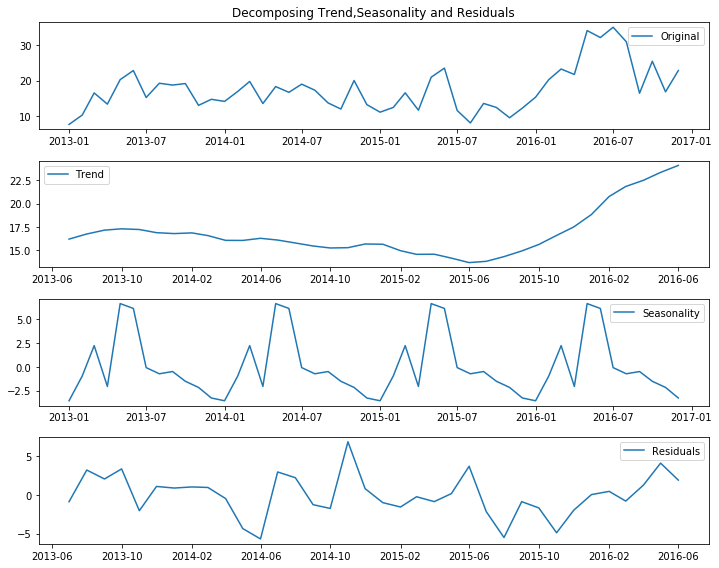

In [795]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_g[['Volume']])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,8))
plt.subplot(411)
plt.title('Decomposing Trend,Seasonality and Residuals')
plt.plot(data_g['Volume'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
#data_q=pd.DataFrame(data=residual)
#data_q=data_q.dropna()
#p_valu_adf=adfuller(data_q['Volume'].values,regression='c',autolag='AIC')[1]
#print(p_valu_adf)

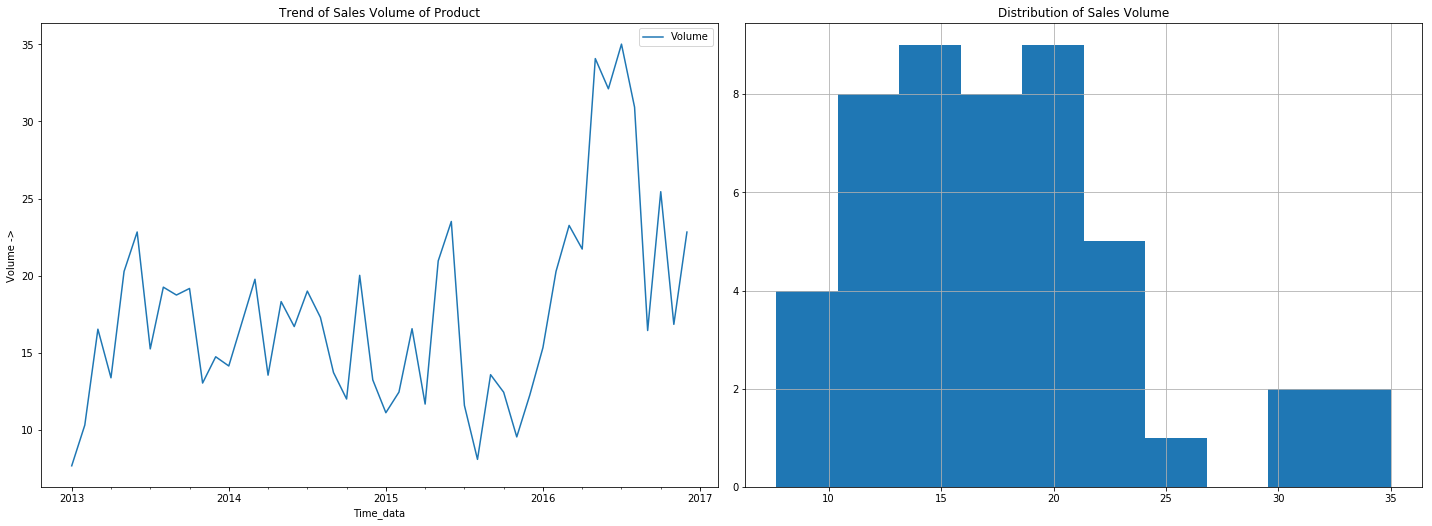

In [817]:
fig=plt.figure(figsize=(20,14))
ax1=fig.add_subplot(221)
data_req[['Volume']].plot(ax=ax1)
ax1.set_ylabel("Volume ->")
ax2=fig.add_subplot(222)
data_req[['Volume']].hist(bins=10,ax=ax2)
ax1.set_title('Trend of Sales Volume of Product')
ax2.set_title('Distribution of Sales Volume')
fig.tight_layout()
x_up,x_low=np.percentile(data_req['Volume'],[95,5])

In [696]:
p_valu_adf=adfuller(data_req['Volume'].apply(lambda x:x).values,autolag='AIC')[1]
if p_valu_adf<0.05:
        print("This time series data has no unit root. P Value is {}".format(p_valu_adf))
else:
        print("This time series data has unit root. P Value is {}".format(p_valu_adf))

This time series data has no unit root. P Value is 0.009436270100067368


In [703]:
data_req['Volume_diff']=data_req['Volume'].diff()
data_req['Volume_log']=data_req['Volume'].apply(lambda x:np.log(x))
data_req['Volume_sqrt']=data_req['Volume'].apply(lambda x:np.sqrt(x))
data_req['Volume_log_diff']=data_req['Volume_log'].diff()
data_req['Volume_sqrt_diff']=data_req['Volume_sqrt'].diff()
data_req['Volume_square']=data_req['Volume'].apply(lambda x:np.square(x))
data_req['Volume_square_diff']=data_req['Volume_square'].diff()

In [705]:
p_valu_adf=adfuller(data_req['Volume_log_diff'].dropna().values,autolag='AIC')[1]
if p_valu_adf<0.05:
        print("This time series data has no unit root, P Value is {}".format(p_valu_adf))
else:
        print("This time series data has unit root. P Value is {}".format(p_valu_adf))

This time series data has no unit root, P Value is 2.9061402576296124e-10


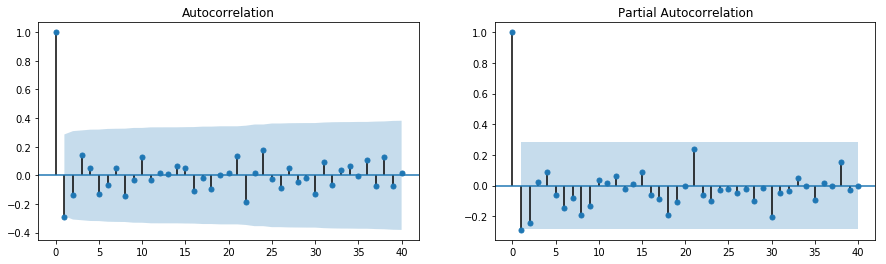

In [706]:
import statsmodels.api as sm
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(data_req['Volume_log_diff'].dropna(), lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(data_req['Volume_log_diff'].dropna(), lags=40, ax=axes[1])

In [734]:
model=SARIMAX(data_req['Volume_log'].dropna(),trend='c',order=(2,1,0),seasonal_order=(1,1,0,6),simple_differencing=False)
res=model.fit(disp=False)
print(res.summary())

                                 Statespace Model Results                                
Dep. Variable:                        Volume_log   No. Observations:                   48
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 6)   Log Likelihood                 -16.735
Date:                           Fri, 25 May 2018   AIC                             43.471
Time:                                   01:02:09   BIC                             52.827
Sample:                               01-01-2013   HQIC                            47.006
                                    - 12-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0045      0.067     -0.068      0.946      -0.135       0.126
ar.L1         -0.3622      0.171     -2.114

0.504255988998


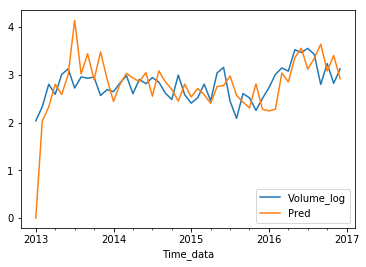

In [735]:
data_req['Pred']=res.predict(start='2013-01-01',end='2016-12-01')
data_req[['Volume_log','Pred']].plot()
print(np.sqrt(mean_squared_error(data_req['Volume_log'],data_req['Pred'])))
data_req[['Pred_exp']]=data_req[['Pred']].apply(lambda x:np.exp(x))

9.71079199605


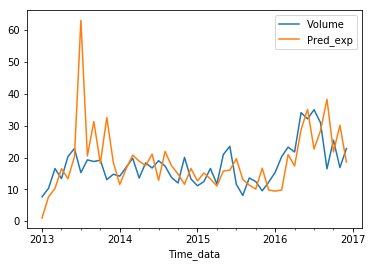

In [785]:
data_req[['Volume','Pred_exp']].plot()
rmse=np.sqrt(mean_squared_error(data_req['Volume'],data_req['Pred_exp']))
print(np.sqrt(mean_squared_error(data_req['Volume'],data_req['Pred_exp'])))

(48, 2) (48, 2)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


[Text(0,0.5,'Product_Volume'),
 Text(0.5,0,'Year-Month'),
 Text(0.5,1,'Volume Prediction with RMSE= 9.71079199605')]

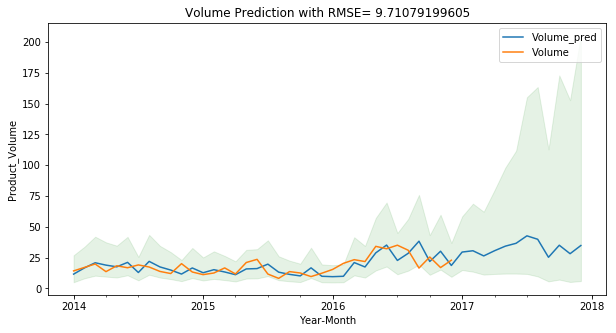

In [791]:
dt_final=pd.DataFrame(index=pd.date_range(start='2013-01-01',end='2017-12-01',freq='MS'))
dt_final.loc[:,'Volume_log_pred']=res.predict(start='2013-01-01',end='2017-12-01')
dt_final.loc[:,'Volume_pred']=np.exp(pred_val['Volume_log_pred'])
dt_final=pd.concat([dt_final,data_req['Volume']],axis=1)
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
dt_final[['Volume_pred','Volume']]['2014-01-01':].plot(ax=ax)
ci=dt_final[['Volume_pred','Volume']]['2014-01-01':]
confi=pd.DataFrame(res.get_prediction(start='2013-01-01',end='2017-12-01').conf_int()).apply(lambda x:np.exp(x))
confi1=confi.loc['2014-01-01':,].copy()
print(confi1.shape,ci.shape)
ax.fill_between(ci.index,confi1['lower Volume_log'],confi1['upper Volume_log'],color='g',alpha=0.1)
ax.set(xlabel="Year-Month",ylabel='Product_Volume',title='Volume Prediction with RMSE= {}'.format(str(rmse)))